<a href="https://colab.research.google.com/github/Jushef/Stock-Market-Analysis/blob/main/Mean_Variance_Portafolio_Theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
plt.style.use('seaborn')
rcParams['figure.figsize'] = (20,10)
rcParams['font.family'] = 'serif'
rcParams['figure.titlesize'] = 17
np.set_printoptions(precision=4, suppress=True, formatter={'float': lambda x: f'{x:6.5f}'})

In [2]:
pip install yfinance

     |████████████████████████████████| 6.4 MB 17.8 MB/s 
     |████████████████████████████████| 63 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [37]:
import yfinance

data = yfinance.download (tickers = ['AAPL', 'MSFT', 'INTC', 'AMZN', 'GLD'], start = "2012-01-01", end = "2021-12-31", 
                              interval = "1d", auto_adjust = True, treads = True, period='99y')

[*********************100%***********************]  5 of 5 completed


In [38]:
data = data.iloc[:, :5]
data.head()

Close                                              
                 AAPL        AMZN         GLD       INTC       MSFT
Date                                                               
2012-01-03  12.575912  179.029999  155.919998  18.147919  21.623135
2012-01-04  12.643500  177.509995  156.710007  18.569452  22.132011
2012-01-05  12.783869  177.610001  157.779999  18.783911  22.358173
2012-01-06  12.917507  182.610001  157.199997  18.672983  22.705502
2012-01-09  12.897018  178.559998  156.500000  18.835682  22.406635

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2012-01-03 to 2021-12-30
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (Close, AAPL)  2516 non-null   float64
 1   (Close, AMZN)  2516 non-null   float64
 2   (Close, GLD)   2516 non-null   float64
 3   (Close, INTC)  2516 non-null   float64
 4   (Close, MSFT)  2516 non-null   float64
dtypes: float64(5)
memory usage: 117.9 KB


In [40]:
data.columns

MultiIndex([('Close', 'AAPL'),
            ('Close', 'AMZN'),
            ('Close',  'GLD'),
            ('Close', 'INTC'),
            ('Close', 'MSFT')],
           )

In [41]:
symbols = [('Close', 'AAPL'),('Close', 'AMZN'),('Close',  'GLD'),('Close', 'INTC'),('Close', 'MSFT')]

In [42]:
rets = np.log(data[symbols] / data[symbols].shift(1)).dropna()

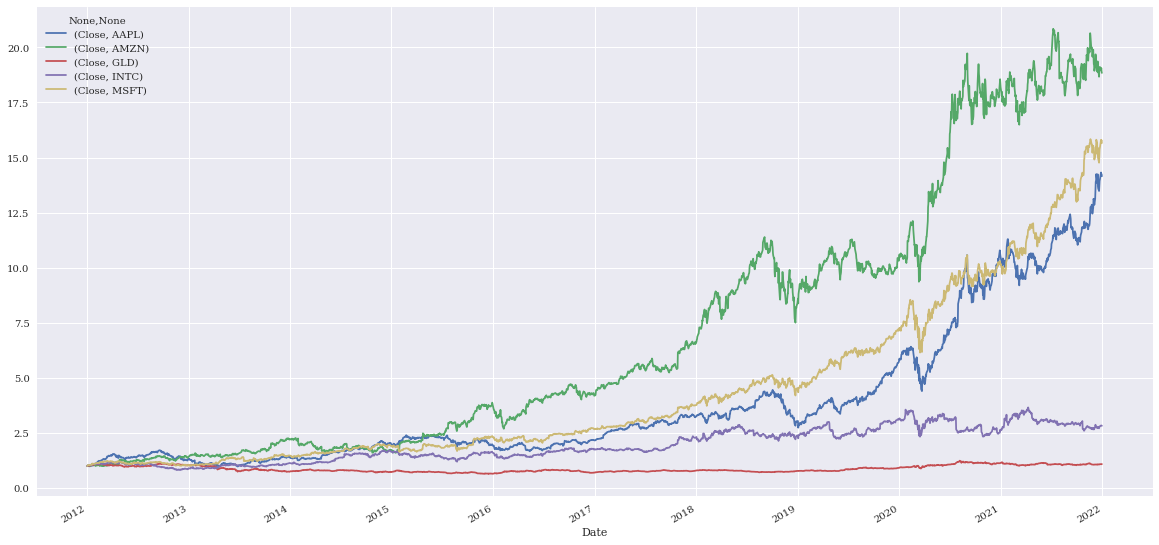

In [43]:
(data[symbols] / data[symbols].iloc[0]).plot(legend=True)

In [44]:
weights = len(rets.columns) * [1 / len(rets.columns)]

In [45]:
def port_return(rets,weights):
  return np.dot(rets.mean(), weights) * 252


port_return(rets, weights)

0.1896222514726484

In [46]:
def port_volatility(rets,weights):
  return np.dot(weights, np.dot(rets.cov() * 252, weights)) ** 0.5


port_volatility(rets,weights)

0.18099008558125224

In [47]:
def port_sharpe(rets,weights):
  return port_return(rets,weights) / port_volatility(rets,weights)


port_sharpe(rets,weights)

1.0476941367460757

In [48]:
w = np.random.random((1000, len(symbols)))
w = (w.T / w.sum(axis=1)).T

In [49]:
w[:5]

array([[0.04084, 0.11069, 0.32696, 0.37384, 0.14767],
       [0.15724, 0.30974, 0.08421, 0.13876, 0.31006],
       [0.14032, 0.18425, 0.15278, 0.24348, 0.27917],
       [0.33958, 0.15890, 0.12743, 0.17885, 0.19525],
       [0.15471, 0.31609, 0.05147, 0.22885, 0.24888]])

In [50]:
pvr = [(port_volatility(rets[symbols], weights), port_return(rets[symbols], weights)) for weights in w]
pvr = np.array(pvr)

In [51]:
psr = pvr[:, 1] / pvr[:, 0]

Text(0.5, 1.0, 'AAPL | MSFT | INTC | AMZN | GLD')

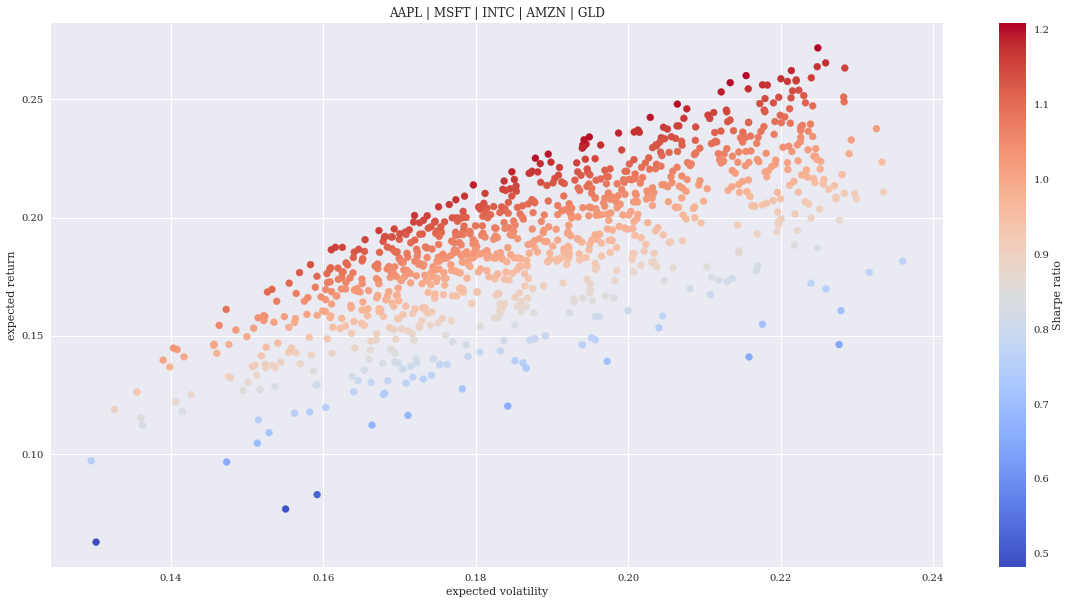

In [52]:
fig = plt.scatter(pvr[:,0], pvr[:,1], c=psr, cmap='coolwarm')

cb = plt.colorbar(fig)
cb.set_label('Sharpe ratio')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.title('AAPL | MSFT | INTC | AMZN | GLD')

In [53]:
bnds = len(symbols) * [(0,1),]
bnds

[(0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]

In [54]:
cons = {'type':'eq', 'fun': lambda weights: weights.sum() - 1}

In [55]:
opt_weights = {}
for year in range(2012,2021):
  rets_ = rets[symbols].loc[f'{year}-01-01':f'{year}-12-31']
  ow = minimize(lambda weights: -port_sharpe(rets_,weights), len(symbols) * [1 / len(symbols)],
                bounds=bnds, constraints= cons)['x']
  opt_weights[year] = ow

In [56]:
opt_weights

{2012: array([0.40137, 0.51415, 0.08448, 0.00000, 0.00000]),
 2013: array([0.02210, 0.40620, 0.00000, 0.26610, 0.30560]),
 2014: array([0.42884, 0.00000, 0.02290, 0.42073, 0.12753]),
 2015: array([0.00000, 1.00000, 0.00000, 0.00000, 0.00000]),
 2016: array([0.16242, 0.01845, 0.50838, 0.00734, 0.30340]),
 2017: array([0.23386, 0.07568, 0.41152, 0.05634, 0.22260]),
 2018: array([0.00000, 0.50402, 0.00000, 0.00000, 0.49598]),
 2019: array([0.23585, 0.00000, 0.55421, 0.00000, 0.20994]),
 2020: array([0.11689, 0.33234, 0.55077, 0.00000, 0.00000])}

In [57]:
res = pd.DataFrame()
for year in range(2012,2021):
  rets_ = rets[symbols].loc[f'{year}-01-01':f'{year}-12-31']
  epv = port_volatility(rets_, opt_weights[year])
  epr = port_return(rets_, opt_weights[year])
  esr = epr / epv
  rets_ = rets[symbols].loc[f'{year + 1}-01-01':f'{year + 1}-12-31']
  rpv = port_volatility(rets_, opt_weights[year])
  rpr = port_return(rets_, opt_weights[year])
  rsr = rpr / rpv
  res = res.append(pd.DataFrame({'epv':epv, 'epr':epr, 'esr':esr,
                                 'rpv':rpv, 'rpr':rpr, 'rsr':rsr},
                                 index = [year + 1]))
  

res

,epv,epr,esr,rpv,rpr,rsr
2013,0.224231,0.287151,1.280606,0.183276,0.241316,1.316680
2014,0.175033,0.373747,2.135298,0.188464,0.077531,0.411386
2015,0.157951,0.330806,2.094349,0.208911,0.000953,0.004563
2016,0.326731,0.778330,2.382172,0.296565,0.103869,0.350242
2017,0.107722,0.103524,0.961029,0.079561,0.240254,3.019744
2018,0.085448,0.267927,3.135559,0.158695,0.042469,0.267616
2019,0.303887,0.220699,0.726254,0.198170,0.329937,1.664921
2020,0.100358,0.336581,3.353790,0.239175,0.337545,1.411287
2021,0.220958,0.379132,1.715859,0.132640,0.019805,0.149314


In [58]:
res.mean()

epv    0.189147
epr    0.341988
esr    1.976102
rpv    0.187273
rpr    0.154853
rsr    0.955084
dtype: float64

In [59]:
res[['epv','rpv']].corr()

,epv,rpv
epv,1.000000,0.482945
rpv,0.482945,1.000000


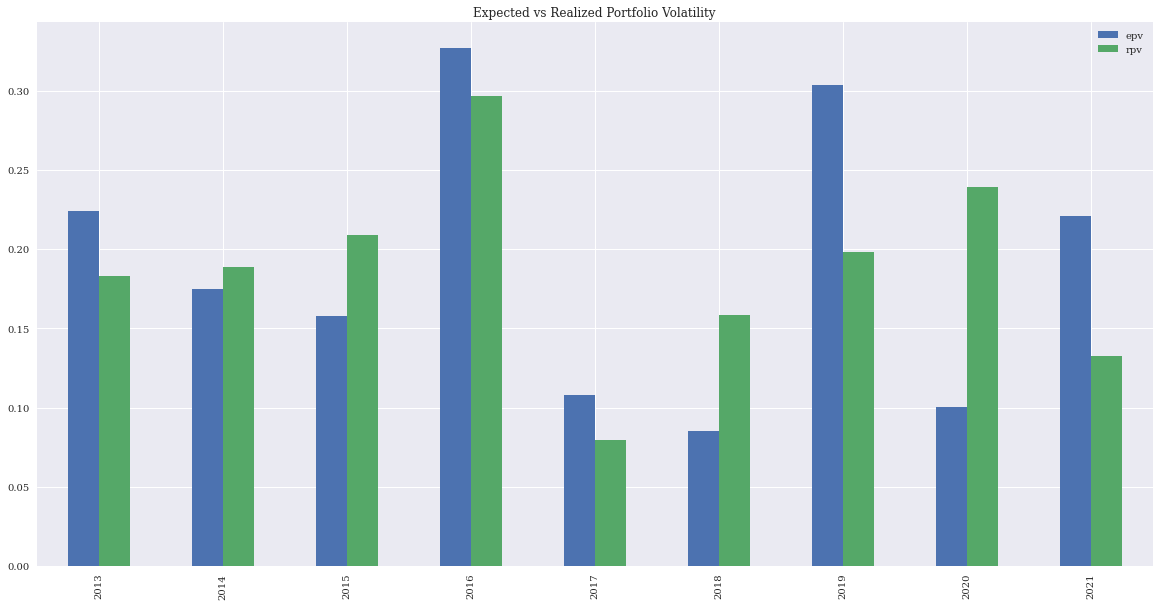

In [60]:
res[['epv','rpv']].plot(kind='bar', title='Expected vs Realized Portfolio Volatility', legend=True)

In [61]:
res[['epr','rpr']].corr()

,epr,rpr
epr,1.000000,-0.340389
rpr,-0.340389,1.000000


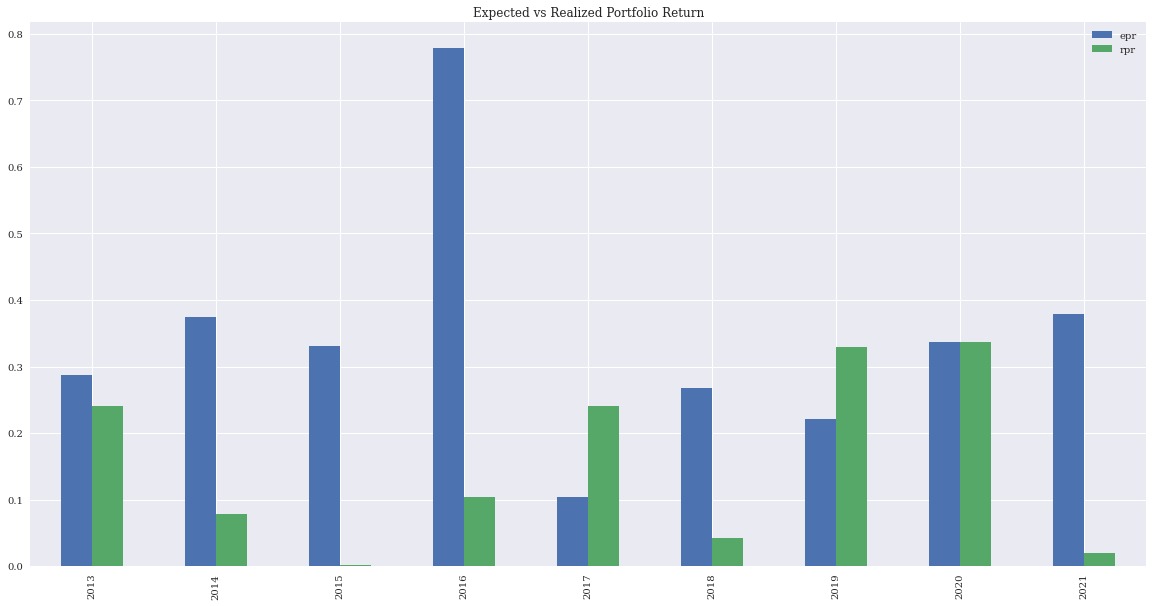

In [62]:
res[['epr','rpr']].plot(kind='bar', title='Expected vs Realized Portfolio Return', legend=True)

In [63]:
res[['esr','rsr']].corr()

,esr,rsr
esr,1.000000,-0.507641
rsr,-0.507641,1.000000


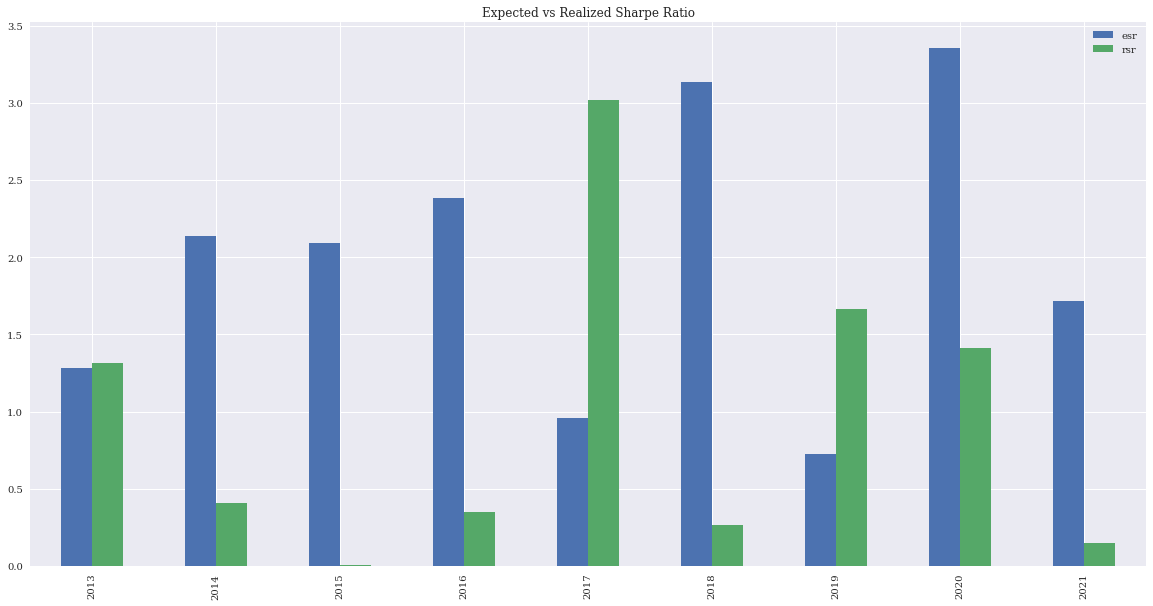

In [64]:
res[['esr','rsr']].plot(kind='bar', title='Expected vs Realized Sharpe Ratio', legend=True)